# PyTorch MNIST example

Data loader:
1. Perform data preprocessing by modifying the Dataloader to  read from the csv file.
2. Split the dataset into Train, Validation and Test sets. Create their corresponding Dataloaders.

Model:
1. Develop a deep learning model with a) one CNN block and b) 2 CNN block to solve this classiﬁcation task. (Remember a CNN block = CNN layer + ReLU activation + Maxpool layer)
2. Train and evaluate your models to establish a baseline of performance.
3. Finalize your models to make predictions on new images.
4. Tweak the network's hyper-parameters to make each model overﬁt and underﬁt.

Optimization:
1. Diagnose the models for each case (overﬁt/underﬁt), and explain the model's behavior by using the learning curves (learning curves are plots of training and validation losses for each epoch).
2. Benchmark your model's performance using SGD, Momentum, and ADAM optimization techniques.

Discussion:
1. Discuss if adding the second CNN block has improved the model performance.
2. Experiment with kernel_size 3 and 5 for the CNN layer.

In [5]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [6]:
print(f"train_data: {train_data},\n test_data: {test_data}")

train_data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor(),
 test_data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Visualize the data

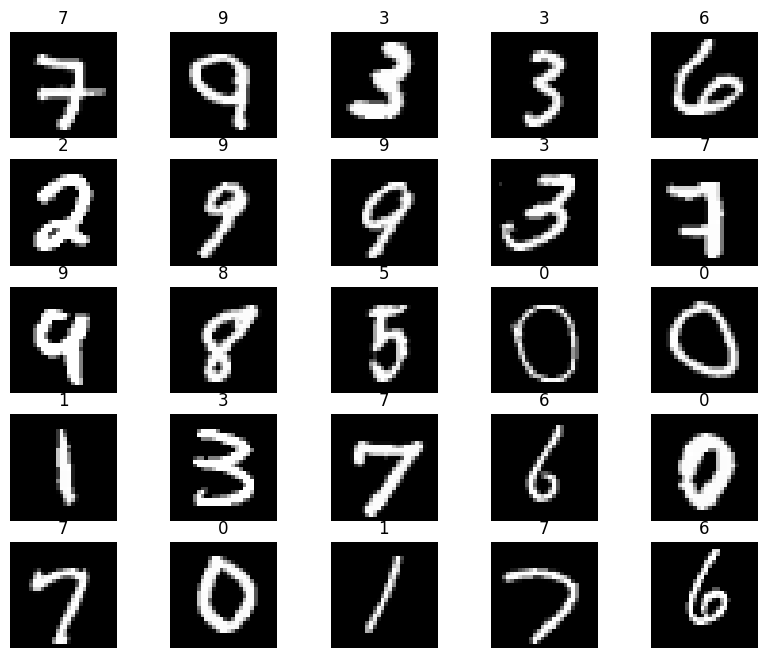

In [7]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Building `DataLoaders` classes to load data

In [8]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)
loaders = {
    'train' : train_loader,
    'test': test_loader,
}

In [9]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000014503282420>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x00000145038C1790>}


## Using the `dataloader`

torch.Size([100, 1, 28, 28])


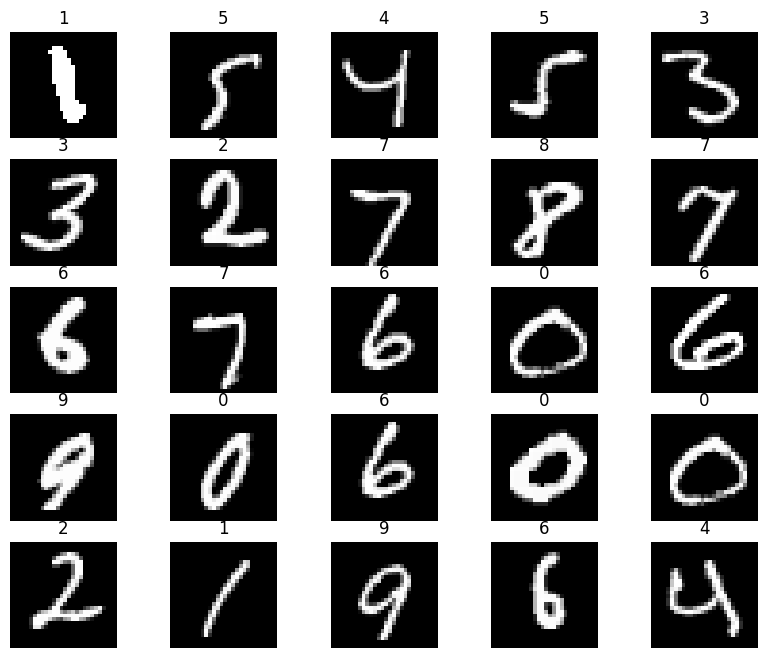

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

imgs, labels = next(iter(loaders['train']))
print(imgs.shape)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx,:,:,:], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [11]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [12]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function

In [13]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Optimizer

In [14]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Train the model

In [15]:
num_epochs = 10

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            output = cnn(images)
            loss = loss_func(output, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward() # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            

In [16]:
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1240
Epoch [1/10], Step [200/600], Loss: 0.1623
Epoch [1/10], Step [300/600], Loss: 0.0817
Epoch [1/10], Step [400/600], Loss: 0.0460
Epoch [1/10], Step [500/600], Loss: 0.0709
Epoch [1/10], Step [600/600], Loss: 0.0537
Epoch [2/10], Step [100/600], Loss: 0.0235
Epoch [2/10], Step [200/600], Loss: 0.0291
Epoch [2/10], Step [300/600], Loss: 0.0263
Epoch [2/10], Step [400/600], Loss: 0.0948
Epoch [2/10], Step [500/600], Loss: 0.0815
Epoch [2/10], Step [600/600], Loss: 0.0930
Epoch [3/10], Step [100/600], Loss: 0.0086
Epoch [3/10], Step [200/600], Loss: 0.0393
Epoch [3/10], Step [300/600], Loss: 0.0407
Epoch [3/10], Step [400/600], Loss: 0.0558
Epoch [3/10], Step [500/600], Loss: 0.0874
Epoch [3/10], Step [600/600], Loss: 0.0538
Epoch [4/10], Step [100/600], Loss: 0.0197
Epoch [4/10], Step [200/600], Loss: 0.0597
Epoch [4/10], Step [300/600], Loss: 0.0055
Epoch [4/10], Step [400/600], Loss: 0.0270
Epoch [4/10], Step [500/600], Loss: 0.0292
Epoch [4/10

## Test the model on test dataset

In [17]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [18]:
test()

Test Accuracy of the model on the 10000 test images: 0.99


## Print predictions

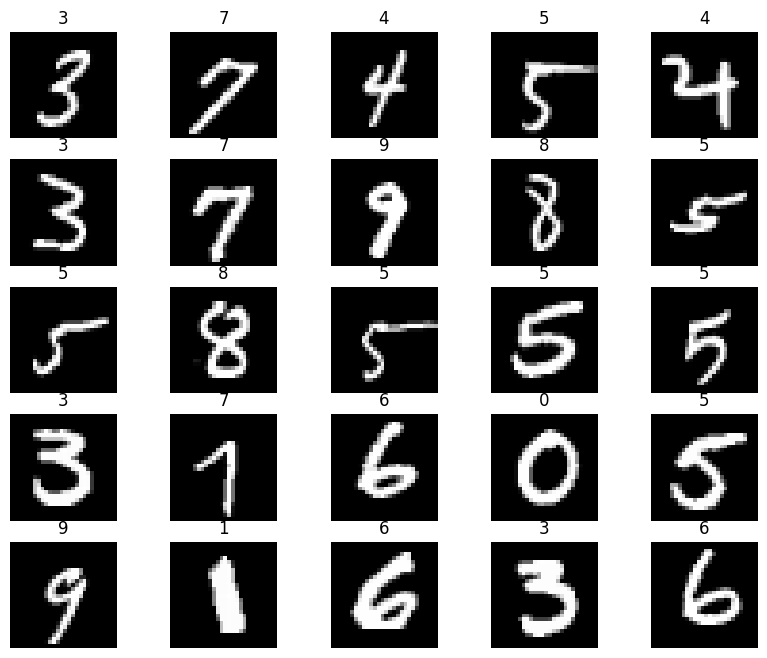

Prediction number: 	 [3 7 4 5 4 3 7 9 8 5 5 8 5 5 5 3 7 6 0 5 9 1 6 3 6]
Actual number: 	 	 [3 7 4 5 4 3 7 9 8 5 5 8 5 5 5 3 7 6 0 5 9 1 6 3 6]


In [19]:
imgs, lbls  = next(iter(loaders['test']))
true_labels = lbls[:25].numpy()

test_output = cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f'Prediction number: \t {pred_labels}')
print(f'Actual number: \t \t {true_labels}')